In [26]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import random

In [2]:
# Importing birth rate data
birthData = pd.read_csv("Data/Birth_Rate_clean.csv")
birthData.tail()

,Data Series,2022 Dec,2022 Nov,2022 Oct,2022 Sep,2022 Aug,2022 Jul,2022 Jun,2022 May,2022 Apr,...,1960 Oct,1960 Sep,1960 Aug,1960 Jul,1960 Jun,1960 May,1960 Apr,1960 Mar,1960 Feb,1960 Jan
10,Total Female Live-Births By Ethnic Group,1422,1452,1506,1539,1458,1426,1379,1420,1306,...,2754,2478,2583,2547,2451,2586,2388,2396,2166,2360
11,Malays,308,323,333,363,319,287,330,320,331,...,474,441,472,426,413,432,393,418,402,394
12,Chinese,825,797,856,869,799,831,748,831,705,...,2013,1754,1856,1848,1794,1910,1776,1756,1523,1701
13,Indians,158,182,161,163,150,173,155,142,154,...,218,243,200,218,210,196,179,178,192,227
14,Other Ethnic Groups,131,150,156,144,190,135,146,127,116,...,49,40,55,55,34,48,40,44,49,38


In [3]:
# Data cleaning
# Update index name
birthData = birthData.rename(columns = {'Data Series':'Date'})
birthData.set_index('Date',inplace=True)
birthData = birthData.rename(columns=lambda x: x.strip())
birthData.columns = pd.DatetimeIndex(birthData.columns).to_period('M')
# birthData.head()

# Switch rows and columns (Tranpose)
birthData = birthData.T
birthData = birthData.rename(columns=lambda x: x.strip())
birthData = birthData.sort_index()
birthData.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 756 entries, 1960-01 to 2022-12
Freq: M
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   Total Live-Births By Ethnic Group         756 non-null    int64
 1   Malays                                    756 non-null    int64
 2   Chinese                                   756 non-null    int64
 3   Indians                                   756 non-null    int64
 4   Other Ethnic Groups                       756 non-null    int64
 5   Total Male Live-Births By Ethnic Group    756 non-null    int64
 6   Malays                                    756 non-null    int64
 7   Chinese                                   756 non-null    int64
 8   Indians                                   756 non-null    int64
 9   Other Ethnic Groups                       756 non-null    int64
 10  Total Female Live-Births By Ethnic Group  7

<AxesSubplot:>

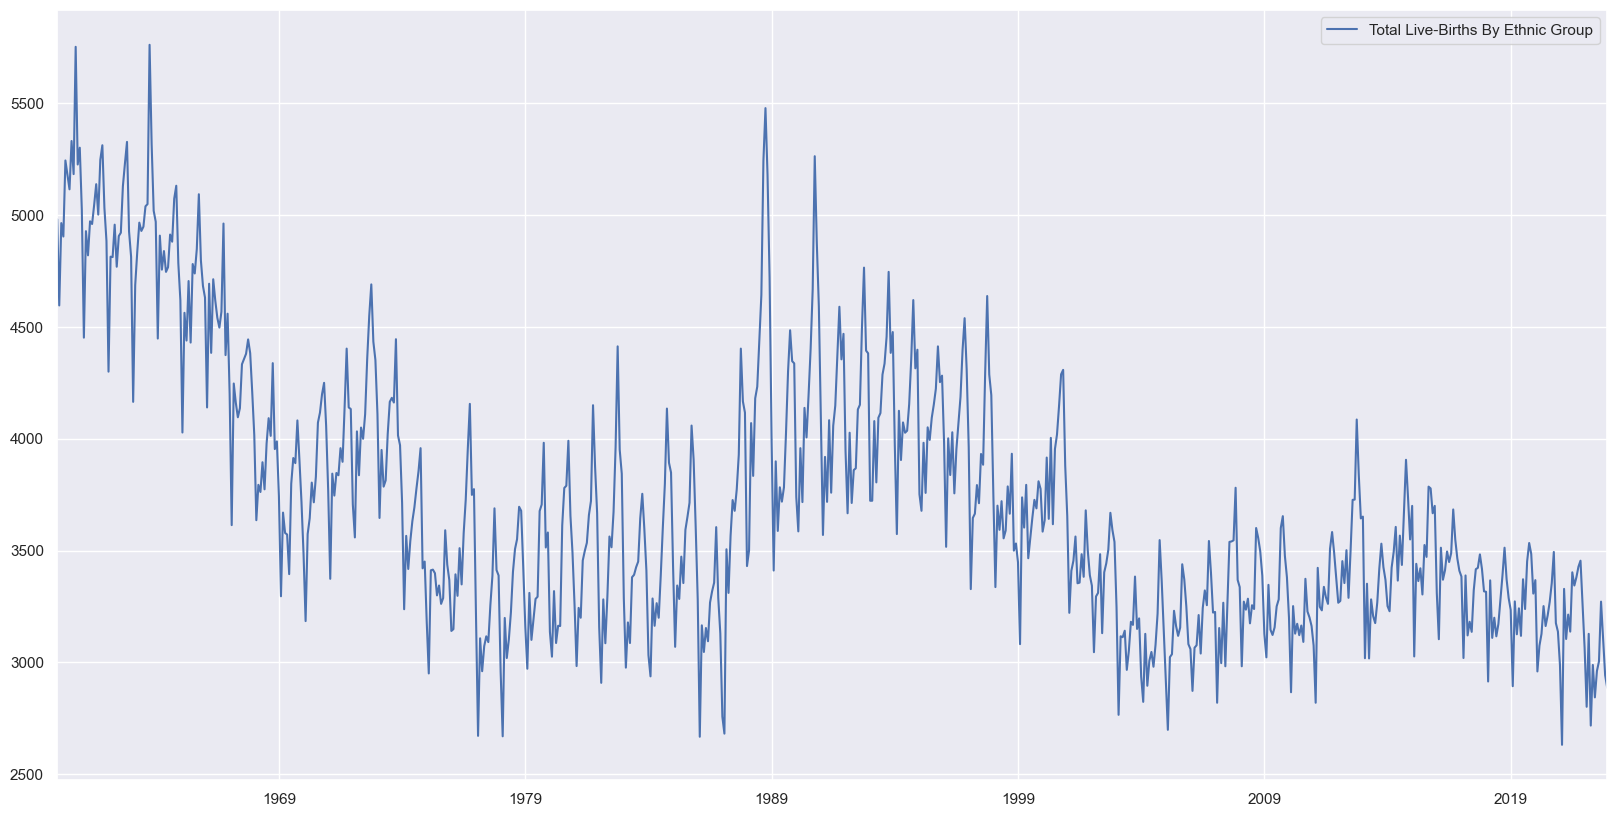

In [4]:
babies = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])

babies.head()
babies = babies.astype('int64')
babies.plot(figsize=(20, 10))

## Variable: Housing Prices
- Dataset is found across multiple csv files, so used `concat` to put all into 1 dataframe
- Standardized the date to `YYYY-MM` following the date format for the birth count dataset
- Standardized the naming convention for `flat_type` and `flat_model`
    - Adding a hypen rather than space
    - Change to full uppercase
- Ignoring `flat_model`, using `flat_type` instead
- Remove outliers for each `flat_type`
- As there are multiple `resale_price` for the same `flat_type` on the same `Date`, getting average of those rounded to 2 decimal places

In [5]:
# Variable: Housing Prices
houseResale = pd.concat(map(pd.read_csv, ['Data/Resale Flat Prices/Resale Approval Date 1990-1999.csv', 'Data/Resale Flat Prices/Resale Approval Date 2000-Feb-2012.csv', 'Data/Resale Flat Prices/Resale Registration Date Mar-2012-Dec-2014.csv', 'Data/Resale Flat Prices/Resale Registration Date Jan-2015-Dec-2016.csv', 'Data/Resale Flat Prices/Resale Registration Date Jan-2017-Onwards.csv']))
houseResale = houseResale.rename(columns = {'month':'Date'})
birthData = birthData.rename(columns=lambda x: x.strip())
houseResale['Date'] = pd.to_datetime(houseResale['Date'])
houseResale['Date'] = houseResale['Date'].dt.strftime('%Y-%m')

# Standardizing flat_type and flat_models
houseResale['flat_type'] = ['MULTI-GENERATION' if x=='MULTI GENERATION' else x for x in houseResale['flat_type']]
houseResale['flat_model'] = [x.upper() for x in houseResale['flat_model']]

tempFrame = houseResale[['Date', 'flat_type', 'flat_model', 'resale_price']].copy()

# Removing outliers
flatType = ['1 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']
separateType = []

for flat in flatType:
    temp = tempFrame.loc[tempFrame['flat_type'] == flat]
    Q3 = temp['resale_price'].quantile(0.25)
    Q1 = temp['resale_price'].quantile(0.75)
    IQR = Q1-Q3
    separateType.append(temp[~((temp['resale_price'] < (Q1 - 1.5*IQR)) | (temp['resale_price'] > (Q3 + 1.5*IQR)))])

# Ignore flat_model
tempFrame = pd.concat(separateType).reset_index().drop(['index'], axis=1)
tempFrame = tempFrame.groupby(['Date', 'flat_type'])['resale_price'].mean().round(2).to_frame()
tempFrame = tempFrame.round(2)
tempFrame = tempFrame.rename(columns={'resale_price': 'avg_resale'}).reset_index()

In [6]:
tempFrame.head()

,Date,flat_type,avg_resale
0,1990-01,3 ROOM,77980.00
1,1990-01,4 ROOM,149500.00
2,1990-02,3 ROOM,75690.91
3,1990-02,4 ROOM,152533.33
4,1990-03,3 ROOM,82060.00


In [7]:
# Getting avg_resale dataframe for specific flat_type
temp1R = tempFrame.loc[tempFrame['flat_type'] == '1 ROOM']
temp1R = temp1R.set_index('Date')
temp1R.index = pd.to_datetime(temp1R.index).to_period('M')

temp3R = tempFrame.loc[tempFrame['flat_type'] == '3 ROOM']
temp3R = temp3R.set_index('Date')
temp3R.index = pd.to_datetime(temp3R.index).to_period('M')

temp4R = tempFrame.loc[tempFrame['flat_type'] == '4 ROOM']
temp4R = temp4R.set_index('Date')
temp4R.index = pd.to_datetime(temp4R.index).to_period('M')

temp5R = tempFrame.loc[tempFrame['flat_type'] == '5 ROOM']
temp5R = temp5R.set_index('Date')
temp5R.index = pd.to_datetime(temp5R.index).to_period('M')

tempEx = tempFrame.loc[tempFrame['flat_type'] == 'EXECUTIVE']
tempEx = tempEx.set_index('Date')
tempEx.index = pd.to_datetime(tempEx.index).to_period('M')

tempMg = tempFrame.loc[tempFrame['flat_type'] == 'MULTI-GENERATION']
tempMg = tempMg.set_index('Date')
tempMg.index = pd.to_datetime(tempMg.index).to_period('M')

print('Count by Room Type')
print('1 Room:  ', len(temp1R))
print('3 Room:  ', len(temp3R))
print('4 Room:  ', len(temp4R))
print('5 Room:  ', len(temp5R))
print('Ex Room: ', len(tempEx))
print('Mg Room: ', len(tempMg))

Count by Room Type
1 Room:   153
3 Room:   399
4 Room:   396
5 Room:   378
Ex Room:  366
Mg Room:  202


<AxesSubplot:>

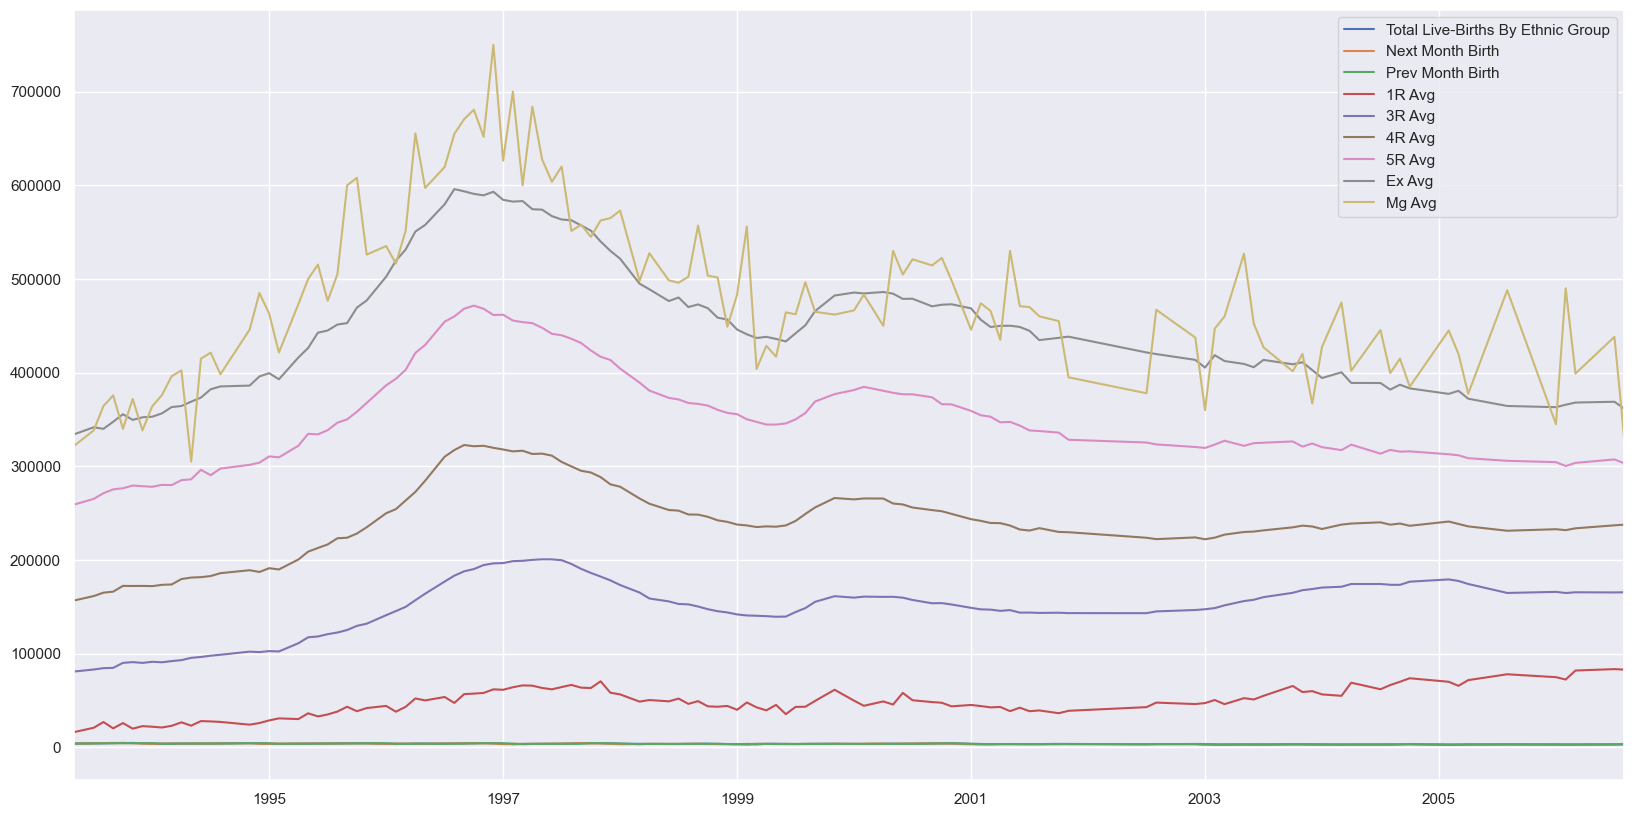

In [8]:
housingBaby = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])
housingBaby['Next Month Birth'] = housingBaby['Total Live-Births By Ethnic Group'].shift(-1)
housingBaby['Prev Month Birth'] = housingBaby['Total Live-Births By Ethnic Group'].shift(1)
housing1R = housingBaby.join(temp1R['avg_resale'], how='inner').rename(columns={'avg_resale': '1R Avg'})
housing3R = housingBaby.join(temp3R['avg_resale'], how='inner').rename(columns={'avg_resale': '3R Avg'})
housing4R = housingBaby.join(temp4R['avg_resale'], how='inner').rename(columns={'avg_resale': '4R Avg'})
housing5R = housingBaby.join(temp5R['avg_resale'], how='inner').rename(columns={'avg_resale': '5R Avg'})
housingEx = housingBaby.join(tempEx['avg_resale'], how='inner').rename(columns={'avg_resale': 'Ex Avg'})
housingMg = housingBaby.join(tempMg['avg_resale'], how='inner').rename(columns={'avg_resale': 'Mg Avg'})
housingMerge = pd.concat([housing1R, housing3R, housing4R, housing5R, housingEx, housingMg], axis=1, join='inner')
housingMerge = housingMerge.loc[:,~housingMerge.columns.duplicated(keep='first')]
housingMerge.plot(figsize=(20, 10))

In [9]:
housingMerge.info()
housingMerge.corr()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 117 entries, 1993-05 to 2006-08
Freq: M
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Total Live-Births By Ethnic Group  117 non-null    int64  
 1   Next Month Birth                   117 non-null    float64
 2   Prev Month Birth                   117 non-null    float64
 3   1R Avg                             117 non-null    float64
 4   3R Avg                             117 non-null    float64
 5   4R Avg                             117 non-null    float64
 6   5R Avg                             117 non-null    float64
 7   Ex Avg                             117 non-null    float64
 8   Mg Avg                             117 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 9.1 KB


,Total Live-Births By Ethnic Group,Next Month Birth,Prev Month Birth,1R Avg,3R Avg,4R Avg,5R Avg,Ex Avg,Mg Avg
Total Live-Births By Ethnic Group,1.000000,0.849218,0.848082,-0.472296,-0.332959,-0.020290,0.230668,0.286764,0.250351
Next Month Birth,0.849218,1.000000,0.763069,-0.439507,-0.331712,-0.024035,0.217193,0.265917,0.267820
Prev Month Birth,0.848082,0.763069,1.000000,-0.492476,-0.353167,-0.038297,0.220302,0.279113,0.276994
1R Avg,-0.472296,-0.439507,-0.492476,1.000000,0.872786,0.661126,0.409396,0.318346,0.310646
3R Avg,-0.332959,-0.331712,-0.353167,0.872786,1.000000,0.908315,0.729726,0.662460,0.591258
4R Avg,-0.020290,-0.024035,-0.038297,0.661126,0.908315,1.000000,0.943722,0.904494,0.806424
5R Avg,0.230668,0.217193,0.220302,0.409396,0.729726,0.943722,1.000000,0.991013,0.889156
Ex Avg,0.286764,0.265917,0.279113,0.318346,0.662460,0.904494,0.991013,1.000000,0.890597
Mg Avg,0.250351,0.267820,0.276994,0.310646,0.591258,0.806424,0.889156,0.890597,1.000000


## Analysis
- Too few entries, likely due to the intersection of the different housing types
- See if there is a way to remove some of these columns, to get more data points
- `1R Avg` does not have a good enough correlation with any of the averages such that it can be removed
- After some research, it seems that 3R, 4R and 5R are the most common amongst young couples/families. [Source](https://www.mynicehome.gov.sg/hdb-how-to/buy-your-flat/a-guide-to-hdb-bto-flat-types/)
- Hence, updating dataframe to include only 3R, 4R and 5R
    - Fortunately, they have the most data points among the averages

In [10]:
housingUpdate = pd.concat([housing3R, housing4R, housing5R], axis=1, join='inner')
housingUpdate = housingUpdate.loc[:,~housingUpdate.columns.duplicated(keep='first')]
housingUpdate.info()
housingUpdate.corr()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 374 entries, 1991-07 to 2022-12
Freq: M
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Total Live-Births By Ethnic Group  374 non-null    int64  
 1   Next Month Birth                   373 non-null    float64
 2   Prev Month Birth                   374 non-null    float64
 3   3R Avg                             374 non-null    float64
 4   4R Avg                             374 non-null    float64
 5   5R Avg                             374 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 20.5 KB


,Total Live-Births By Ethnic Group,Next Month Birth,Prev Month Birth,3R Avg,4R Avg,5R Avg
Total Live-Births By Ethnic Group,1.000000,0.849316,0.846784,-0.511237,-0.437702,-0.316570
Next Month Birth,0.849316,1.000000,0.790944,-0.510863,-0.437168,-0.318515
Prev Month Birth,0.846784,0.790944,1.000000,-0.506806,-0.432860,-0.306218
3R Avg,-0.511237,-0.510863,-0.506806,1.000000,0.984295,0.918193
4R Avg,-0.437702,-0.437168,-0.432860,0.984295,1.000000,0.969473
5R Avg,-0.316570,-0.318515,-0.306218,0.918193,0.969473,1.000000


<AxesSubplot:>

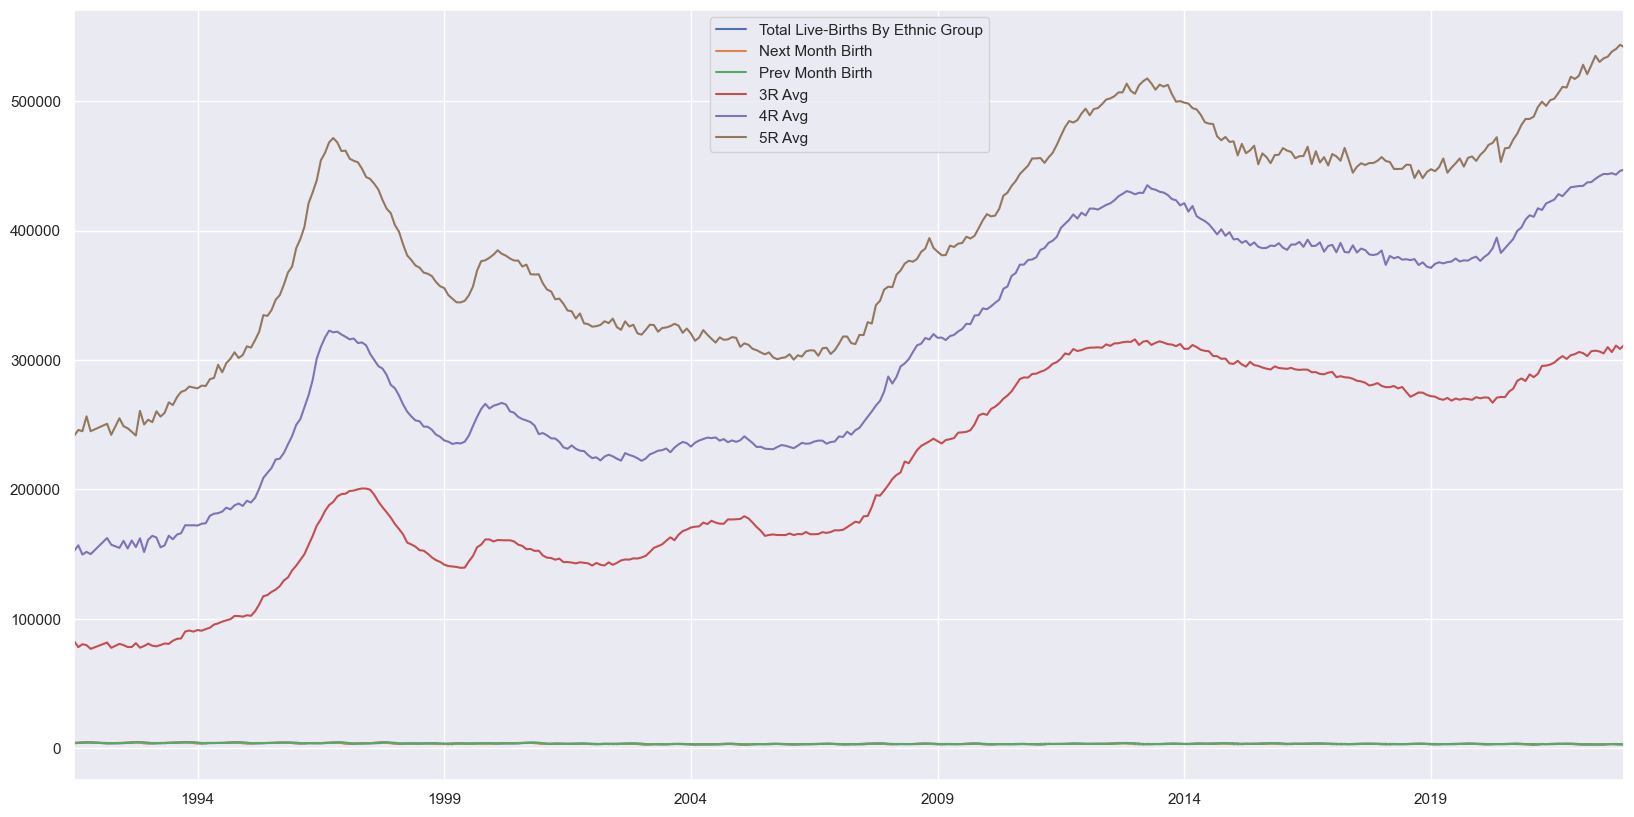

In [11]:
housingUpdate.plot(figsize=(20, 10))

## Classification: Random Forest
- Goal: From the available variables this month, predict the rise/fall of the next month's birth rate
- Available Data:
    - Current/Prev Month Birth Count
    - 3-Room/4-Room/5-Room Average

## Classification Model Performance Metrics
- Accuracy:  Number of correct predictions
- Precision: Proportion of true positives out of all positive predictions
- Recall:    Proportion of true positives out of all actual positive cases
- F1 Score:  Harmonic mean of precision and recall

In [27]:
results = []

for i in range(250):
    seed = random.randint(0, 10000)
    # Step 1: Create binary target variable
    housingUpdate['Rise-Fall'] = (housingUpdate['Total Live-Births By Ethnic Group'] > housingUpdate['Next Month Birth']).astype(int)

    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = housingUpdate[['Total Live-Births By Ethnic Group', 'Prev Month Birth', '3R Avg', '4R Avg', '5R Avg']]

    # Step 2.2: Response
    y = housingUpdate['Rise-Fall']

    # Step 3: Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # Step 4: Create Random Forest Classifier object
    rf = RandomForestClassifier(n_estimators=100, max_depth=5)

    # Step 5: Fit model to training data
    rf.fit(X_train, y_train)

    # Step 6: Make predictions on test data
    y_pred = rf.predict(X_test)

    # Step 7: Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confuse = confusion_matrix(y_test, y_pred)

    results.append((seed, accuracy, precision, recall, f1, confuse))


# Sort results by F1 score in descending order
results.sort(key=lambda x: x[4], reverse=True)

In [30]:
results = results[:5]

for i in range(5):
    print('----------------------------------------------')
    print(f"Random state {results[i][0]}:")
    print(f'Accuracy  = {results[i][1]:.4f}')
    print(f'Precision = {results[i][2]:.4f}')
    print(f'Recall    = {results[i][3]:.4f}')
    print(f'F1 score  = {results[i][4]:.4f}')

print('----------------------------------------------')

----------------------------------------------
Random state 5348:
Accuracy  = 0.7600
Precision = 0.8788
Recall    = 0.6744
F1 score  = 0.7632
----------------------------------------------
Random state 1059:
Accuracy  = 0.7600
Precision = 0.8286
Recall    = 0.7073
F1 score  = 0.7632
----------------------------------------------
Random state 6946:
Accuracy  = 0.7467
Precision = 0.7250
Recall    = 0.7838
F1 score  = 0.7532
----------------------------------------------
Random state 1127:
Accuracy  = 0.7467
Precision = 0.8529
Recall    = 0.6744
F1 score  = 0.7532
----------------------------------------------
Random state 2811:
Accuracy  = 0.7200
Precision = 0.6957
Recall    = 0.8205
F1 score  = 0.7529
----------------------------------------------


Text(0.5, 1.0, 'Random Seed 2811')

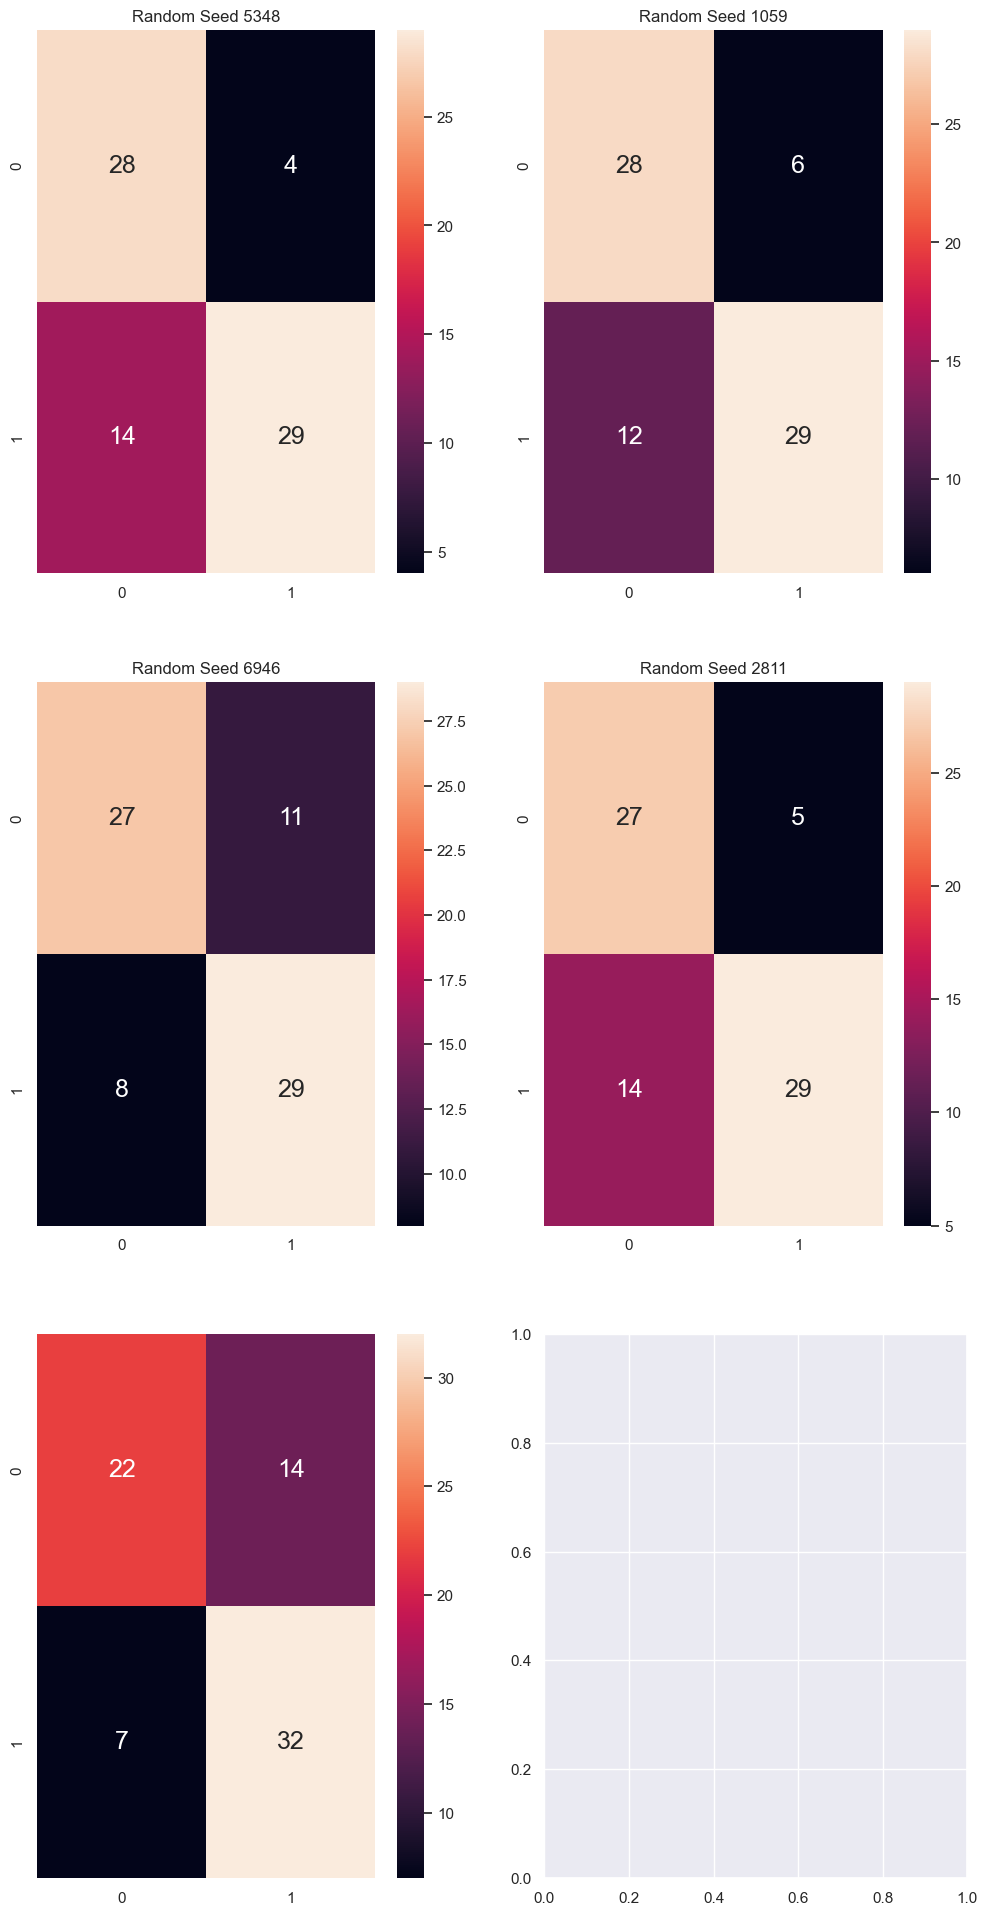

In [38]:
# Confusion Matrix
a, axes = plt.subplots(3, 2, figsize=(12, 24))
sb.heatmap(results[0][5], annot = True, fmt=".0f", annot_kws={"size": 18}, ax=axes[0][0])
axes[0][0].set_title(f'Random Seed {results[0][0]}')
sb.heatmap(results[1][5], annot = True, fmt=".0f", annot_kws={"size": 18}, ax=axes[0][1])
axes[0][1].set_title(f'Random Seed {results[1][0]}')
sb.heatmap(results[2][5], annot = True, fmt=".0f", annot_kws={"size": 18}, ax=axes[1][0])
axes[1][0].set_title(f'Random Seed {results[2][0]}')
sb.heatmap(results[3][5], annot = True, fmt=".0f", annot_kws={"size": 18}, ax=axes[1][1])
axes[1][1].set_title(f'Random Seed {results[3][0]}')
sb.heatmap(results[4][5], annot = True, fmt=".0f", annot_kws={"size": 18}, ax=axes[2][0])
axes[1][1].set_title(f'Random Seed {results[4][0]}')


In [29]:
print(f'Average Accuracy:  {sum([i[1] for i in results])/5:.4f}')
print(f'Average Precision: {sum([i[2] for i in results])/5:.4f}')
print(f'Average Recall:    {sum([i[3] for i in results])/5:.4f}')
print(f'Average F1 Score:  {sum([i[4] for i in results])/5:.4f}')

Average Accuracy:  0.7467
Average Precision: 0.7962
Average Recall:    0.7321
Average F1 Score:  0.7572


## Final Verdict for Housing Prices
The average metrics from the top 5 random seeds are more than 0.7

While not an especially good model, its still decent